### Comparing Models

Now that you have seen a variety of models for regression and classification problems, it is good to step back and weigh the pros and cons of these options.  In the case of classification models, there are at least three things to consider:

1. Is the model good at handling imbalanced classes?
2. Does the model train quickly?
3. Does the model yield interpretable results?

Depending on your dataset and goals, the importance of these considerations will vary from project to project.  Your goal is to review our models to this point and discuss the pros and cons of each.  Two example datasets are offered as a way to offer two very different tasks where interpretability of the model may be of differing importance.

### Data and Task

Your goal is to discuss the pros and cons of Logistic Regression, Decision Trees, KNN, and SVM for the tasks below.  Consider at least the three questions above and list any additional considerations you believe are important to determining the "best" model for the task.  Share your response with your peers on the class discussion board.  

**TASK 1**: Predicting Customer Churn

Suppose you are tasked with producing a model to predict customer churn.  Which of your classification models would you use and what are the pros and cons of this model for this task?  Be sure to consider interpretability, imbalnced classes, and the speed of training.



In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

In [17]:
from sklearn.datasets import load_digits

The data is loaded below.  Note that the handwritten digit data is already split into features and target (`digits`, `labels`). 

In [18]:
churn = pd.read_csv('data/telecom_churn.csv')

In [19]:
#churn data
churn.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [20]:
X_train, X_test, y_train, y_test = train_test_split(churn.drop('Churn', axis=1), churn['Churn'], test_size = 0.2, random_state = 42) 

In [21]:
def evaluate(name, model, preprocessor, params):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    start = time.time()
    grid = GridSearchCV(pipe, param_grid=params, scoring = 'accuracy')
    grid.fit(X_train, y_train)
    end = time.time()
    preds = grid.best_estimator_.predict(X_test)
    train_acc = grid.score(X_train, y_train)
    test_acc = grid.score(X_test, y_test)

    return pd.DataFrame([{
        'name': name, 
        'fit-time': round((end - start), 2),
        'accuracy': round(accuracy_score(y_test, preds), 2),
        'precision': round(precision_score(y_test, preds, average='weighted'), 2),
        'recall': round(recall_score(y_test, preds, average='weighted'), 2),
        'f1-score': round(f1_score(y_test, preds, average='weighted'), 2),
        'train_accuracy': round(train_acc, 2),
        'best_params': grid.best_params_,
        'preds': preds
    }])

In [22]:
transformer = make_column_transformer(
    (OneHotEncoder(drop = 'if_binary', handle_unknown='ignore'), X_train.keys()),
    remainder = StandardScaler()
)

result = pd.DataFrame()

df = evaluate('KNeighborsClassifier', KNeighborsClassifier(), transformer, {'model__n_neighbors': range(1, 33, 2)})
result = pd.concat([result, df], ignore_index=True)

df = evaluate('LogisticRegression', LogisticRegression(), transformer, {'model__C': [0.01,0.1,1,10,100]})
result = pd.concat([result, df], ignore_index=True)

df = evaluate('DecisionTreeClassifier', DecisionTreeClassifier(), transformer, {'model__max_depth': [1,5,10,20]})
result = pd.concat([result, df], ignore_index=True)

df = evaluate('SVC', SVC(), transformer, {'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']})
result = pd.concat([result, df], ignore_index=True)

result.head()

,name,fit-time,accuracy,precision,recall,f1-score,train_accuracy,best_params,preds
0,KNeighborsClassifier,43.38,0.85,0.72,0.85,0.78,0.86,{'model__n_neighbors': 21},"[False, False, False, False, False, False, Fal..."
1,LogisticRegression,5.22,0.86,0.83,0.86,0.83,0.99,{'model__C': 1},"[False, False, False, False, False, False, Fal..."
2,DecisionTreeClassifier,8.68,0.88,0.88,0.88,0.84,0.89,{'model__max_depth': 5},"[False, False, False, False, False, False, Fal..."
3,SVC,22.57,0.85,0.85,0.85,0.79,0.88,{'model__kernel': 'sigmoid'},"[False, False, False, False, False, False, Fal..."


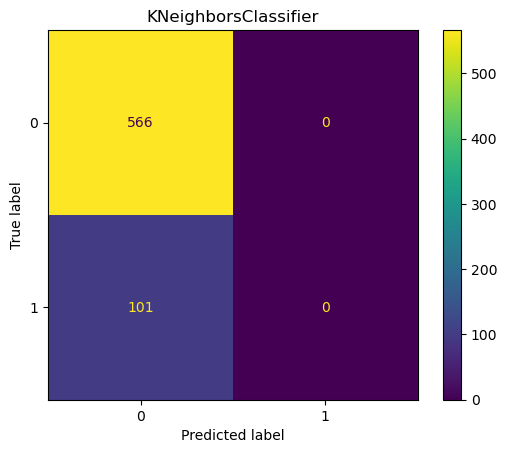

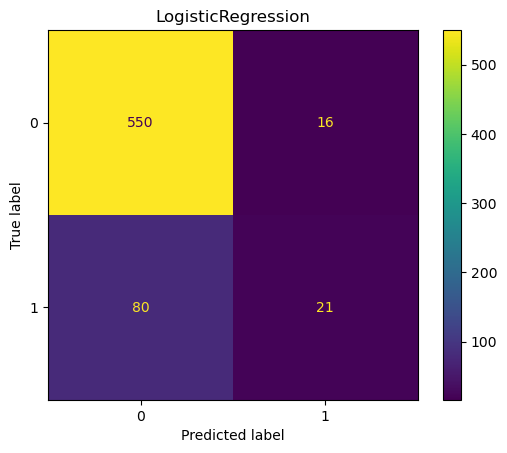

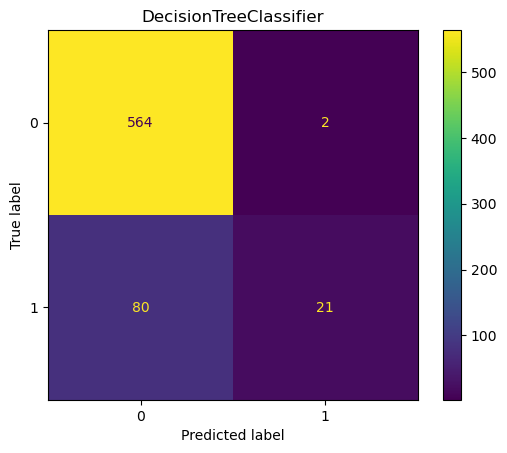

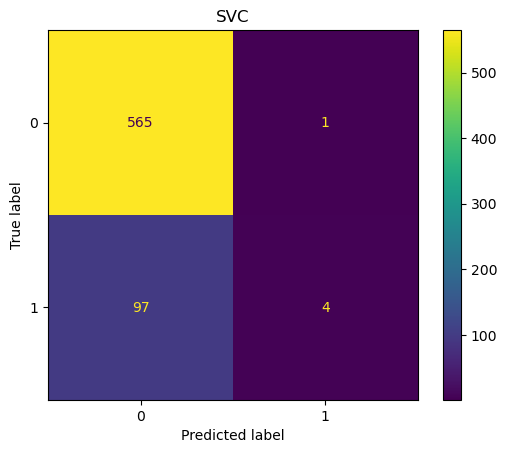

In [23]:
for i in range(0, 4):
    cm = confusion_matrix(y_test, result.at[i,'preds'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()    
    disp.ax_.set_title(result.at[i,'name'])
    plt.show()

**TASK 2**: Recognizing Handwritten Digits

Suppose you are tasked with training a model to recognize handwritten digits.  Which of your classifier would you use here and why?  Again, be sure to consider the balance of classes, speed of training, and importance of interpretability.



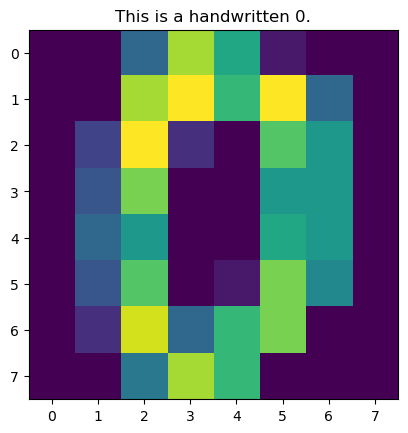

In [24]:
digits, labels = load_digits(return_X_y=True)
#example image
plt.imshow(digits[0].reshape(8, 8))
plt.title('This is a handwritten 0.');

In [25]:
X_train, X_test, y_train, y_test = train_test_split(digits, labels, test_size = 0.2, random_state = 42) 

In [27]:
result = pd.DataFrame()

df = evaluate('KNeighborsClassifier', KNeighborsClassifier(), StandardScaler(), {'model__n_neighbors': range(1, 33, 2)})
result = pd.concat([result, df], ignore_index=True)

df = evaluate('LogisticRegression', LogisticRegression(), StandardScaler(), {'model__C': [0.01,0.1,1,10,100]})
result = pd.concat([result, df], ignore_index=True)

df = evaluate('DecisionTreeClassifier', DecisionTreeClassifier(), StandardScaler(), {'model__max_depth': [1,5,10,20]})
result = pd.concat([result, df], ignore_index=True)

df = evaluate('SVC', SVC(), StandardScaler(), {'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']})
result = pd.concat([result, df], ignore_index=True)

result.head()

,name,fit-time,accuracy,precision,recall,f1-score,train_accuracy,best_params,preds
0,KNeighborsClassifier,13.43,0.97,0.97,0.97,0.97,0.99,{'model__n_neighbors': 3},"[6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, ..."
1,LogisticRegression,2.53,0.97,0.97,0.97,0.97,1.00,{'model__C': 1},"[6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, ..."
2,DecisionTreeClassifier,0.96,0.83,0.83,0.83,0.83,1.00,{'model__max_depth': 20},"[6, 9, 3, 7, 2, 1, 5, 3, 5, 7, 2, 6, 4, 0, 4, ..."
3,SVC,2.83,0.98,0.98,0.98,0.98,1.00,{'model__kernel': 'rbf'},"[6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, ..."


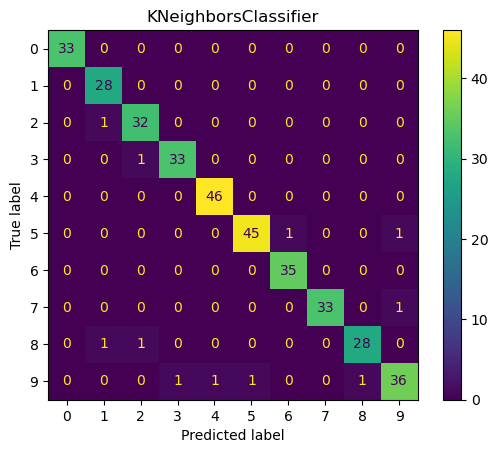

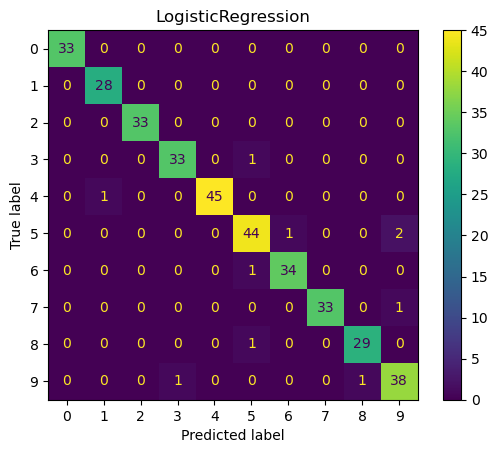

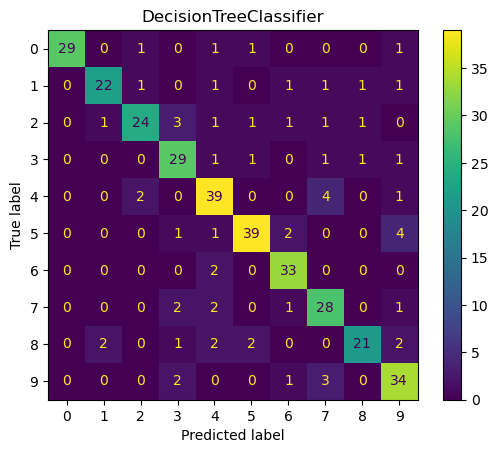

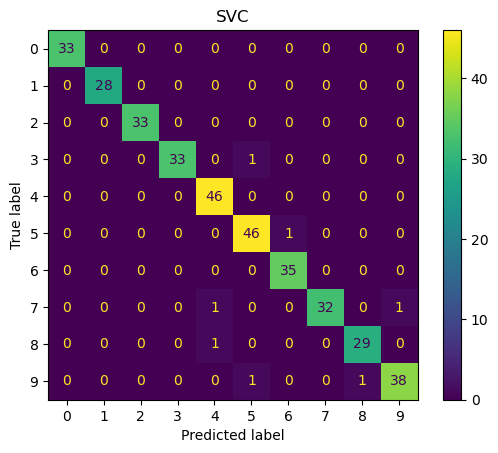

In [28]:
for i in range(0, 4):
    cm = confusion_matrix(y_test, result.at[i,'preds'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()    
    disp.ax_.set_title(result.at[i,'name'])
    plt.show()